In [2]:
import brightway2 as bw
import numpy as np
import matplotlib.pyplot as plt

In [3]:
bw.projects.set_current("test")
db = bw.Database("ecoinvent_remind_default_2030")

methods =  [
    ('ReCiPe Midpoint (H) V1.13', 'agricultural land occupation', 'ALOP'),
    ('ReCiPe Midpoint (H) V1.13', 'climate change', 'GWP100'),
    ('ReCiPe Midpoint (H) V1.13', 'fossil depletion', 'FDP'),
    ('ReCiPe Midpoint (H) V1.13', 'freshwater ecotoxicity', 'FETPinf'),
    ('ReCiPe Midpoint (H) V1.13', 'freshwater eutrophication', 'FEP'),
    ('ReCiPe Midpoint (H) V1.13', 'human toxicity', 'HTPinf'),
    ('ReCiPe Midpoint (H) V1.13', 'ionising radiation', 'IRP_HE'),
    ('ReCiPe Midpoint (H) V1.13', 'marine ecotoxicity', 'METPinf'),
    ('ReCiPe Midpoint (H) V1.13', 'marine eutrophication', 'MEP'),
    ('ReCiPe Midpoint (H) V1.13', 'metal depletion', 'MDP'),
    ('ReCiPe Midpoint (H) V1.13', 'natural land transformation', 'NLTP'),
    ('ReCiPe Midpoint (H) V1.13', 'ozone depletion', 'ODPinf'),
    ('ReCiPe Midpoint (H) V1.13', 'particulate matter formation', 'PMFP'),
    ('ReCiPe Midpoint (H) V1.13', 'photochemical oxidant formation', 'POFP'),
    ('ReCiPe Midpoint (H) V1.13', 'terrestrial acidification', 'TAP100'),
    ('ReCiPe Midpoint (H) V1.13', 'terrestrial ecotoxicity', 'TETPinf'),
    ('ReCiPe Midpoint (H) V1.13', 'urban land occupation', 'ULOP'),
    ('ReCiPe Midpoint (H) V1.13', 'water depletion', 'WDP')
]

Find activities

In [4]:
car = None
steel = None
for act in db:
    if act["name"] == "transport, passenger car, medium size, diesel, EURO 4" and act["location"] == "RER":
        car = act
    if act["name"] == "market for reinforcing steel" and act["location"] == "GLO":
        steel = act


In [5]:
demand = {car: 1}

First, let's see the full impacts:

In [6]:
lca = bw.LCA(demand=demand)
lca.lci()
impacts_full = []
for m in methods:
    lca.switch_method(m)
    lca.lcia()
    impacts_full.append(lca.score)
    print("{}: {:f}".format(m[1], lca.score))

agricultural land occupation: 0.026356
climate change: 0.277589
fossil depletion: 0.096165
freshwater ecotoxicity: 0.018905
freshwater eutrophication: 0.000035
human toxicity: 0.078780
ionising radiation: 0.023851
marine ecotoxicity: 0.016445
marine eutrophication: 0.000149
metal depletion: 0.025927
natural land transformation: -0.000023
ozone depletion: 0.000000
particulate matter formation: 0.000454
photochemical oxidant formation: 0.001174
terrestrial acidification: 0.000959
terrestrial ecotoxicity: 0.000457
urban land occupation: 0.008957
water depletion: 0.002201


In [7]:
lca.supply_array[lca.product_dict[steel.key]]

0.007621901129510877

## Approach A

In [8]:
sbar = lca.supply_array
sbar[lca.product_dict[steel.key]] = 0

In [9]:
fbar = lca.technosphere_matrix * sbar

In [10]:
steel.key

('ecoinvent_remind_default_2030', '33754bdc65e8f50fa85abf6a65b61f5e')

In [11]:
demandA = {}
for k, idx in lca.product_dict.items():
    demandA[k] = fbar[idx]

In [12]:
impactsA  = []
lcaA = bw.LCA(demand=demandA)
lcaA.lci()

for m in methods:
    lcaA.switch_method(m)
    lcaA.lcia()
    impactsA.append(lcaA.score)
    print("{}: {:f}".format(m[1], lcaA.score))

agricultural land occupation: 0.026356
climate change: 0.277589
fossil depletion: 0.096165
freshwater ecotoxicity: 0.018905
freshwater eutrophication: 0.000035
human toxicity: 0.078780
ionising radiation: 0.023851
marine ecotoxicity: 0.016445
marine eutrophication: 0.000149
metal depletion: 0.025927
natural land transformation: -0.000023
ozone depletion: 0.000000
particulate matter formation: 0.000454
photochemical oxidant formation: 0.001174
terrestrial acidification: 0.000959
terrestrial ecotoxicity: 0.000457
urban land occupation: 0.008957
water depletion: 0.002201


## Approach B

In [13]:
lca.lci(demand)

In [14]:
steel_demand = lca.supply_array[lca.product_dict[steel.key]]
demandB = {
    car: 1,
    steel: -steel_demand
}

In [15]:
impactsB  = []
lcaB = bw.LCA(demand=demandB)
lcaB.lci()

for m in methods:
    lcaB.switch_method(m)
    lcaB.lcia()
    impactsB.append(lcaB.score)
    print("{}: {:f}".format(m[1], lcaB.score))

agricultural land occupation: 0.025947
climate change: 0.264717
fossil depletion: 0.092704
freshwater ecotoxicity: 0.018335
freshwater eutrophication: 0.000029
human toxicity: 0.072726
ionising radiation: 0.022959
marine ecotoxicity: 0.015878
marine eutrophication: 0.000145
metal depletion: 0.018129
natural land transformation: -0.000022
ozone depletion: 0.000000
particulate matter formation: 0.000417
photochemical oxidant formation: 0.001109
terrestrial acidification: 0.000921
terrestrial ecotoxicity: 0.000453
urban land occupation: 0.008689
water depletion: 0.002042


In [16]:
lca.inventory

<2142x31544 sparse matrix of type '<class 'numpy.float64'>'
	with 296053 stored elements in Compressed Sparse Row format>

## Approach C

In [61]:
lcaC = bw.LCA(demand=demand)
lcaC.lci()

In [62]:
i = lcaC.product_dict[car.key]
j = lcaC.product_dict[steel.key]
lcaC.technosphere_matrix[i,j] = 0

Redo LCI (solving the linear system), check that technosphere change is not overwrittten.

In [63]:
lcaC.lci_calculation()

In [64]:
impactsC  = []

for m in methods:
    lcaC.switch_method(m)
    lcaC.lcia()
    impactsC.append(lcaC.score)
    print("{}: {:f}".format(m[1], lcaC.score))

agricultural land occupation: 0.026356
climate change: 0.277589
fossil depletion: 0.096165
freshwater ecotoxicity: 0.018905
freshwater eutrophication: 0.000035
human toxicity: 0.078780
ionising radiation: 0.023851
marine ecotoxicity: 0.016445
marine eutrophication: 0.000149
metal depletion: 0.025927
natural land transformation: -0.000023
ozone depletion: 0.000000
particulate matter formation: 0.000454
photochemical oxidant formation: 0.001174
terrestrial acidification: 0.000959
terrestrial ecotoxicity: 0.000457
urban land occupation: 0.008957
water depletion: 0.002201


## Compare results

In [65]:
import pandas as pd

In [66]:
data_array = np.array([impacts_full, impactsA, impactsB, impactsC]).T
df = pd.DataFrame(
    data=data_array, 
    index=[m[1] for m in methods], 
    columns=["full", "approach A", "approach B", "approach C"]
    )
df

,full,approach A,approach B,approach C
agricultural land occupation,2.635569e-02,2.635569e-02,2.594711e-02,2.635569e-02
climate change,2.775889e-01,2.775889e-01,2.647168e-01,2.775889e-01
fossil depletion,9.616501e-02,9.616501e-02,9.270444e-02,9.616501e-02
freshwater ecotoxicity,1.890489e-02,1.890489e-02,1.833517e-02,1.890489e-02
freshwater eutrophication,3.496055e-05,3.496055e-05,2.901637e-05,3.496055e-05
human toxicity,7.877962e-02,7.877962e-02,7.272617e-02,7.877962e-02
ionising radiation,2.385098e-02,2.385098e-02,2.295914e-02,2.385098e-02
marine ecotoxicity,1.644465e-02,1.644465e-02,1.587831e-02,1.644465e-02
marine eutrophication,1.485405e-04,1.485405e-04,1.451630e-04,1.485405e-04
metal depletion,2.592706e-02,2.592706e-02,1.812883e-02,2.592706e-02


In [67]:
df["rel diff A"] = (df["approach A"] - df["full"]) / df["full"]
df["rel diff B"] = (df["approach B"] - df["full"]) / df["full"]
df["rel diff C"] = (df["approach C"] - df["full"]) / df["full"]
df

,full,approach A,approach B,approach C,rel diff A,rel diff B,rel diff C
agricultural land occupation,2.635569e-02,2.635569e-02,2.594711e-02,2.635569e-02,3.949182e-16,-0.015502,0.000000e+00
climate change,2.775889e-01,2.775889e-01,2.647168e-01,2.775889e-01,0.000000e+00,-0.046371,0.000000e+00
fossil depletion,9.616501e-02,9.616501e-02,9.270444e-02,9.616501e-02,1.587435e-15,-0.035986,0.000000e+00
freshwater ecotoxicity,1.890489e-02,1.890489e-02,1.833517e-02,1.890489e-02,-3.670423e-16,-0.030136,0.000000e+00
freshwater eutrophication,3.496055e-05,3.496055e-05,2.901637e-05,3.496055e-05,-5.814780e-16,-0.170025,0.000000e+00
human toxicity,7.877962e-02,7.877962e-02,7.272617e-02,7.877962e-02,-1.761596e-16,-0.076840,0.000000e+00
ionising radiation,2.385098e-02,2.385098e-02,2.295914e-02,2.385098e-02,1.454635e-16,-0.037392,0.000000e+00
marine ecotoxicity,1.644465e-02,1.644465e-02,1.587831e-02,1.644465e-02,-8.439090e-16,-0.034439,0.000000e+00
marine eutrophication,1.485405e-04,1.485405e-04,1.451630e-04,1.485405e-04,3.649517e-16,-0.022738,0.000000e+00
metal depletion,2.592706e-02,2.592706e-02,1.812883e-02,2.592706e-02,0.000000e+00,-0.300775,-2.676314e-16


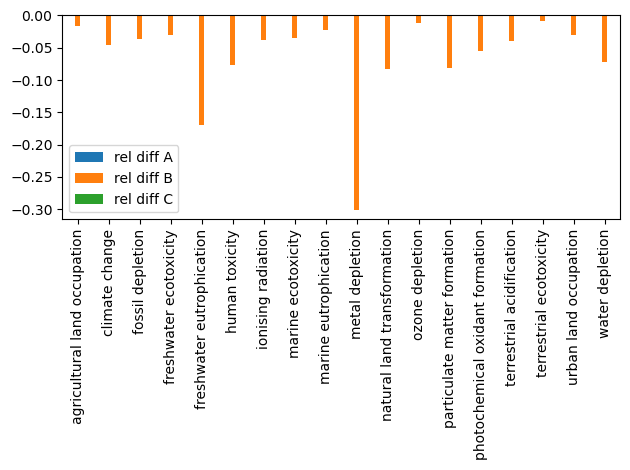

In [68]:
ax = df.plot.bar(y=["rel diff A", "rel diff B", "rel diff C"])
plt.tight_layout()
ax.figure.savefig("rel differences.png")